In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

from model import model

In [3]:
model = model

In [4]:
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

In [5]:
# Make tool list
tools = [search_tool, calculator]

In [6]:
model_with_tools = model.bind_tools(tools)

In [19]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [20]:
# graph nodes
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)  # Executes tool calls

In [21]:
graph = StateGraph(ChatState)

#node
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

#edges
graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

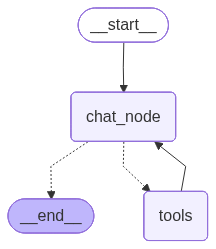

In [22]:
chatbot = graph.compile()
chatbot

In [23]:
# Regular chat
out = chatbot.invoke({"messages": [HumanMessage("Hello!")]})

out["messages"][-1].content

'Hello! How can I help you today?'

In [25]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
out["messages"][-1].content

'2 multiplied by 3 is 6.'

In [28]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of tata using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out["messages"][-1].content)

I cannot use a `get_stock_price` tool as it is not available. I can use `duckduckgo_search` to find out the stock price of Tata, and then use the `calculator` tool to find out how much it would cost to purchase 50 shares. Would you like me to do that?
